<h1 id="header" align="center">
    Cost of apatment at districts of the St. Peterburg
</h1>

---
## Введение

__EDA(Exploratory Data Analysis)__ — разведочный анализ данных, проводимый с целью изучения структуры и свойств данных, выявления в них закономерностей и аномалий, обработки и визуализации.
В EDA используются метрики, которые помогают оценить характеристики набора данных:

![Скриншот с метриками](images\metrics.jpg)

Для данного учебного проекта необходимо следовать, как минимум, __первым двум метрикам__.

### Датасет
    
Обрабатывается набор данных о ценах за квадратный метр квартир по районам от 2005 до 2025 года правил.

У выбранного датасета 3 признака.

Ссылка на веб-источник: https://www.bn.ru/analytics/

Ссылка на сохранённый датасет: https://drive.google.com/uc?id=1REx1HpbXT_duA4L3jfu45RG6xynAbP1p

### Цель разведочного анализа данных

Целью данного EDA является __поиск самых выгодных предложений по квартирам__



---
## Этапы EDA

### Загрузка и сохранение данных, импорт необходимых для анализа библиотек

Работа с датасетом подразумевает создание переменного окружения и установку Conda+Poetry. Подробнее об этом написано в [README.md](../README.md)
Для данного этапа работы были добавлены: numpy, seaborn, openpyxl.

Импортируем первичные библиотеки и загрузим данные:

In [ ]:
import os
import requests
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import pyarrow as pa
import math
%matplotlib inline

# Безопасная очистка (работает и в старых версиях)
if hasattr(pa, "registry"):  # есть только в PyArrow >= 14
    for ext in list(pa.registry.list_extension_types()):
        if "pandas.period" in ext:
            pa.registry.unregister_extension_type(ext)
else:
    print("⚠️ PyArrow без registry API — очистка пропущена (нормально).")


FILE_ID = "1REx1HpbXT_duA4L3jfu45RG6xynAbP1p"
file_url = f"https://drive.google.com/uc?id={FILE_ID}"

# Скачиваем файл
response = requests.get(file_url)
content = response.text

# Убираем лишние кавычки
cleaned = content.replace('"', "")

# Загружаем CSV (первая строка как заголовки)
raw_data = pd.read_csv(StringIO(cleaned), sep=",")

# Приведение типов для числовых колонок
for col in raw_data.columns[1:]:
    raw_data[col] = pd.to_numeric(raw_data[col], errors="coerce")


# Разбор "кривых" дат
def parse_date(val: str):
    months = {
        "janv": 1,
        "fev": 2,
        "mar": 3,
        "apr": 4,
        "maj": 5,
        "ijun": 6,
        "ijul": 7,
        "avg": 8,
        "sen": 9,
        "okt": 10,
        "noja": 11,
        "dek": 12,
    }
    try:
        m, y = val.split("'")
        month = months.get(m, 1)
        year = int("20" + y) if int(y) < 30 else int("19" + y)  # '05 → 2005
        return pd.Timestamp(year=year, month=month, day=1)
    except Exception:
        return pd.NaT


raw_data["Дата"] = raw_data["Дата"].map(parse_date)

# Проверка
print("Первые строки:")
print(raw_data.head(20))
print("\nТипы данных:")
print(raw_data.dtypes)

# Сохранение в Parquet ("brick")
brick_file = "dataset.brick"
raw_data.to_parquet("dataset.brick", engine="fastparquet", index=False)
print(f"\nДанные сохранены в {brick_file}")

# ---- Чтение обратно ----
df = pd.read_parquet("dataset.brick", engine="fastparquet")
print("\nПроверка чтения из brick:")
print(df.head(5))

dataset = raw_data

⚠️ PyArrow без registry API — очистка пропущена (нормально).
Первые строки:
         Дата  o_CАНКТ-ПЕТЕРБУРГ  o_Адмиралтейский  o_Василеостровский  \
0  2005-07-01             33.100            34.634              36.628   
1  2005-08-01             33.025            34.364              36.719   
2  2005-09-01             33.091            34.544              36.474   
3  2005-10-01             33.490            35.001              37.332   
4  2005-11-01             34.067            35.878              37.748   
5  2005-12-01             34.570            35.536              38.388   
6  2006-01-01             34.651            35.367              37.879   
7  2006-02-01             36.033            35.818              38.587   
8  2006-03-01             36.776            36.759              39.488   
9  2006-04-01             38.425            37.856              40.723   
10 2006-05-01             40.458            39.808              42.513   
11 2006-06-01             44.852    

### Первичный просмотр данных

Выведем первые и последние 10 значений датасета, определим количество признаков и их типы данных.

In [40]:
dataset.head(10)

,Дата,o_CАНКТ-ПЕТЕРБУРГ,o_Адмиралтейский,o_Василеостровский,o_Всеволожский,o_Выборгский,o_Калининский,o_Кировский,o_Колпинский,o_Красногвардейский,...,p_Курортный,p_Московский,p_Невский,p_ЛЕНОБЛАСТЬ,p_Петроградский,p_Петродворцовый,p_Приморский,p_Пушкинский,p_Фрунзенский,p_Центральный
0,2005-07-01,33.100,34.634,36.628,22.706,32.037,30.063,30.996,24.812,30.669,...,0.000,31.121,25.345,17.110,53.817,0.000,26.973,0.000,24.132,47.985
1,2005-08-01,33.025,34.364,36.719,22.497,32.134,30.132,31.043,24.752,30.434,...,0.000,30.592,24.985,16.520,53.892,0.000,26.721,0.000,24.199,48.975
2,2005-09-01,33.091,34.544,36.474,22.756,32.450,30.270,31.175,24.848,30.375,...,0.000,30.418,25.354,18.471,53.399,0.000,27.318,0.000,24.101,50.598
3,2005-10-01,33.490,35.001,37.332,22.894,32.753,30.751,31.225,25.028,30.871,...,0.000,30.263,25.425,18.767,54.690,0.000,27.402,0.000,24.362,52.066
4,2005-11-01,34.067,35.878,37.748,23.132,33.344,31.230,31.734,25.346,31.365,...,0.000,31.365,26.050,18.138,54.998,0.000,27.650,0.000,24.586,51.957
5,2005-12-01,34.570,35.536,38.388,23.301,33.825,31.731,32.013,25.467,31.957,...,0.000,32.549,26.272,18.907,56.167,0.000,28.076,0.000,25.069,53.317
6,2006-01-01,34.651,35.367,37.879,23.585,33.814,31.559,31.903,25.435,31.866,...,28.314,32.105,26.484,18.480,60.544,22.031,28.259,24.770,24.752,57.006
7,2006-02-01,36.033,35.818,38.587,24.185,34.527,32.195,32.291,25.953,32.329,...,30.319,31.651,26.678,18.738,63.004,22.195,28.502,26.461,25.052,57.183
8,2006-03-01,36.776,36.759,39.488,24.197,35.735,33.039,32.869,26.324,33.186,...,28.209,31.491,28.043,18.932,62.919,22.351,29.595,24.767,25.088,60.538
9,2006-04-01,38.425,37.856,40.723,24.863,37.831,34.823,34.486,27.078,34.746,...,29.360,34.891,29.744,18.321,68.587,22.703,31.221,25.490,25.647,60.062


In [17]:
dataset.shape

(241, 43)

In [18]:
dataset.dtypes

Дата                   datetime64[ns]
o_CАНКТ-ПЕТЕРБУРГ             float64
o_Адмиралтейский              float64
o_Василеостровский            float64
o_Всеволожский                float64
o_Выборгский                  float64
o_Калининский                 float64
o_Кировский                   float64
o_Колпинский                  float64
o_Красногвардейский           float64
o_Красносельский              float64
o_Кронштадтский               float64
o_Курортный                   float64
o_Московский                  float64
o_Невский                     float64
o_ЛЕНОБЛАСТЬ                  float64
o_Петроградский               float64
o_Петродворцовый              float64
o_Приморский                  float64
o_Пушкинский                  float64
o_Фрунзенский                 float64
o_Центральный                 float64
p_CАНКТ-ПЕТЕРБУРГ             float64
p_Адмиралтейский              float64
p_Василеостровский            float64
p_Всеволожский                float64
p_Выборгский

### Обработка данных

#### Просмотр нулевых значений

Определим наличие пропущенных значений, перед тем как подвергать данные анализу.
Визуально отобразим пропуски:

Text(0, 0.5, 'Sample Number')

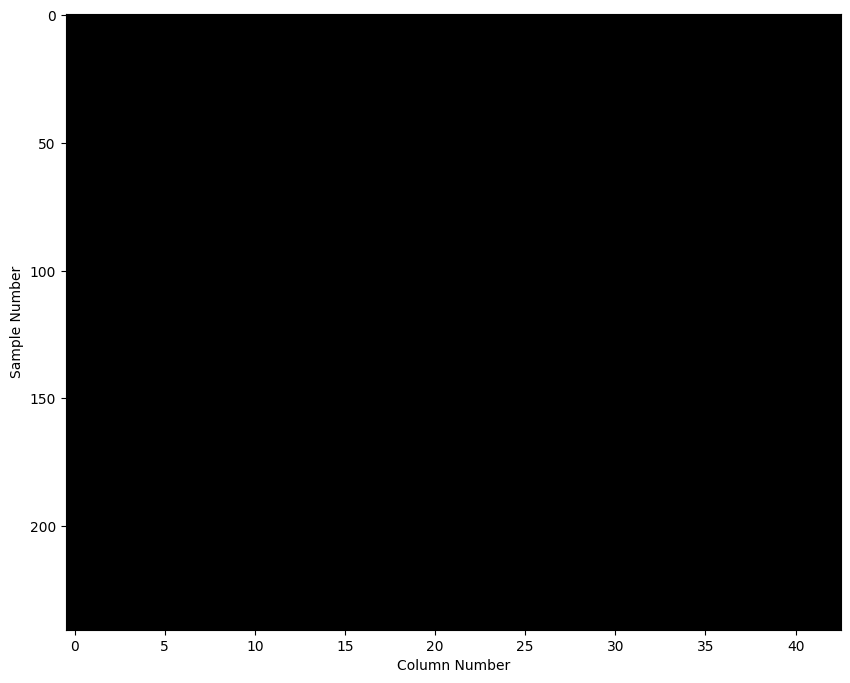

In [19]:
plt.figure(figsize=(10, 8))
plt.imshow(dataset.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

#### Просмотр полноты данных
Как видно, пропущенных значений не имеется. Проверим теперь на полноту данных для проверки


,Дата,o_CАНКТ-ПЕТЕРБУРГ,o_Адмиралтейский,o_Василеостровский,o_Всеволожский,o_Выборгский,o_Калининский,o_Кировский,o_Колпинский,o_Красногвардейский,...,p_Курортный,p_Московский,p_Невский,p_ЛЕНОБЛАСТЬ,p_Петроградский,p_Петродворцовый,p_Приморский,p_Пушкинский,p_Фрунзенский,p_Центральный
Completeness,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


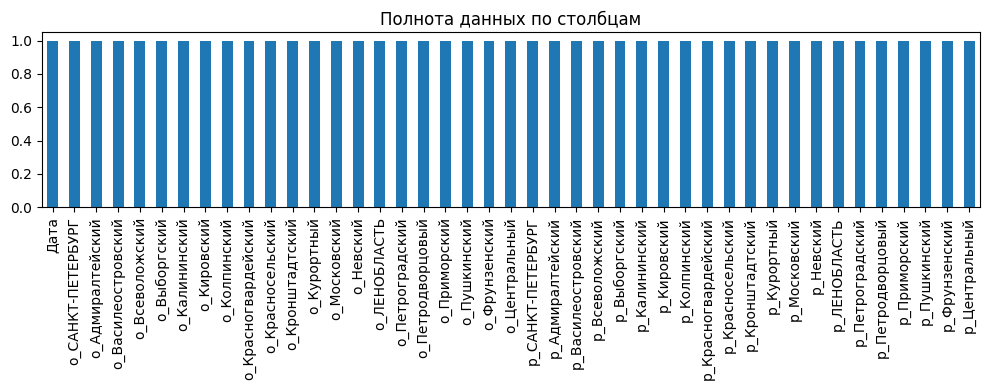

In [26]:
completeness = dataset.notnull().mean() # полнота данных (доля непустых значений)
# метод notnull() возвращает 1 (True), если значение не равно NaN/Null, иначе 0 (False)
# метод mean() вычисляет среднее по столбцу, а т.к. он состоит из 0 и 1, то возвращенное значение равно доле непустых значений
display(completeness.to_frame(name='Completeness').T) # преобразовываем pandas.series в pandas.dataframe

plt.figure(figsize=(10,4)) # график полноты данных по столбцам
completeness.plot(kind='bar') # строим гистограмму
plt.title('Полнота данных по столбцам') # название
plt.tight_layout() #график вписывается в окно вывода
plt.show() # вывод

__Полнота данных__: 100%. Теперь проверим данные на пропуски дат:

In [25]:
# 1️⃣ Определяем диапазон дат
start_date = df['Дата'].min()
end_date = df['Дата'].max()
print(f"📅 Диапазон дат: {start_date.date()} — {end_date.date()}")

# 2️⃣ Проверяем полноту
expected_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
missing = expected_dates.difference(df['Дата'])

if missing.empty:
    print("✅ Все месяцы присутствуют — пропусков нет.")
else:
    print(f"⚠️ Пропущено {len(missing)} месяцев:")
    for d in missing:
        print(" -", d.strftime("%Y-%m"))


📅 Диапазон дат: 2005-07-01 — 2025-07-01
✅ Все месяцы присутствуют — пропусков нет.


__Вывод__: все данные имеются, они без пропусков

#### Проверка на наличие дубликатов:

In [27]:
dups = dataset.duplicated().sum() # проверка дубликатов
# метод duplicated() возвращает pandas.series с bool-значениями, метод sum() суммирует количество дубликатов (True)
print(f'Количество полных дубликатов: {dups}.')

Количество полных дубликатов: 0.


По полученому результату можно сделать вывод, что данные вполне релевантны для анализа

#### Уникальность данных:

In [29]:
# --- Сводная таблица метрик качества данных ---
import pandas as pd

# Количество строк (для процента уникальных)
n_rows = len(df)

metrics = pd.DataFrame({
    'Тип данных': df.dtypes.astype(str),
    'Уникальных': df.nunique(dropna=False)
})

metrics['Процент уникальных'] = round(metrics['Уникальных'] / n_rows * 100, 3)

# Вывод отсортированной таблицы (сначала самые "разнообразные" столбцы)
display(metrics.sort_values('Процент уникальных', ascending=False))


,Тип данных,Уникальных,Процент уникальных
Дата,datetime64[ns],241,100.000
o_Адмиралтейский,float64,241,100.000
o_Василеостровский,float64,241,100.000
o_Калининский,float64,241,100.000
o_Всеволожский,float64,241,100.000
o_Красногвардейский,float64,241,100.000
p_Василеостровский,float64,241,100.000
o_Петродворцовый,float64,241,100.000
o_Московский,float64,241,100.000
o_Курортный,float64,241,100.000


По данной метрике в Кронштадском районе самая стабильная цена за квартиры, выведем график значений цен:

C:\Users\Ilya\AppData\Local\Temp\ipykernel_22444\181716677.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Ilya\miniconda3\envs\my_EDA_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


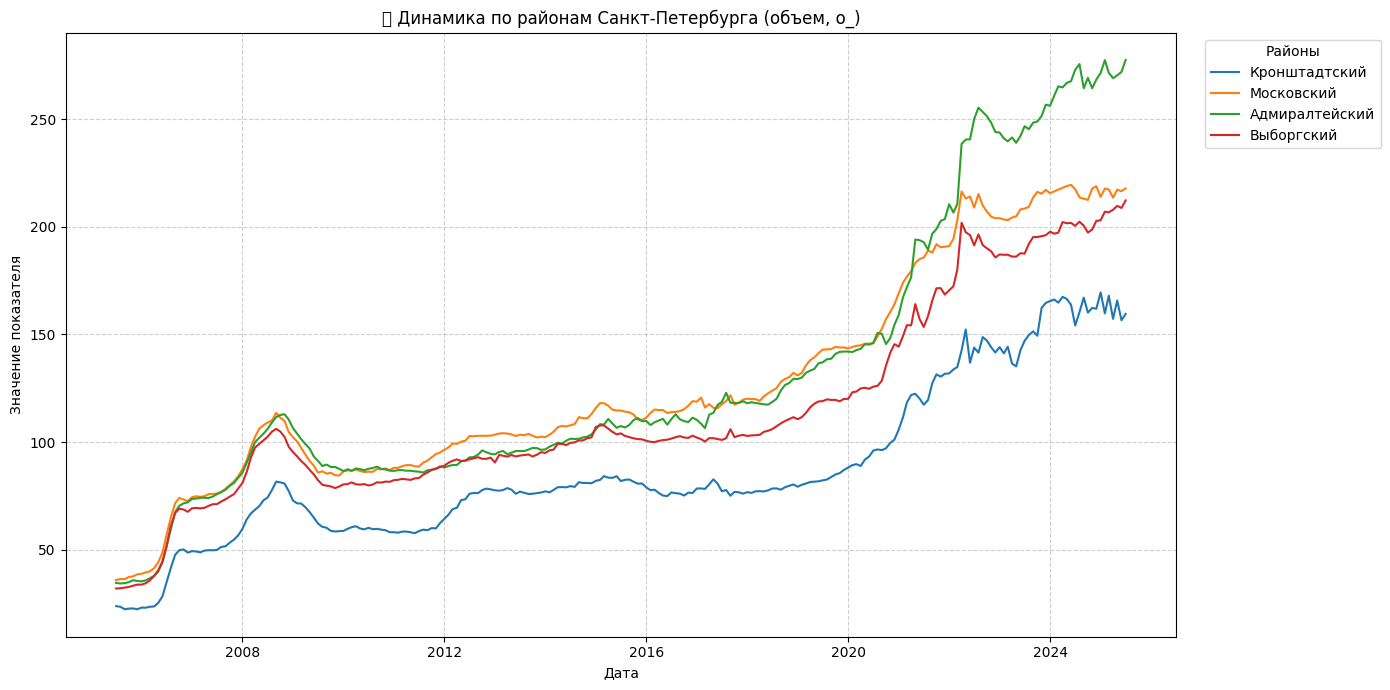

In [31]:
# Сортируем по дате, чтобы линии шли по времени
df = df.sort_values('Дата')

# --- Список районов для сравнения ---
districts = [
    'o_Кронштадтский',
    'o_Московский',
    'o_Адмиралтейский',
    'o_Выборгский'
]

# --- Построение графиков ---
plt.figure(figsize=(14, 7))

for col in districts:
    sns.lineplot(data=df, x='Дата', y=col, label=col.replace('o_', ''))

plt.title('📈 Динамика по районам Санкт-Петербурга (объем, o_)')
plt.xlabel('Дата')
plt.ylabel('Значение показателя')
plt.legend(title='Районы', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


По приведенному графику тяжело визуально воспринимать информацию. Разделим графики по районам:

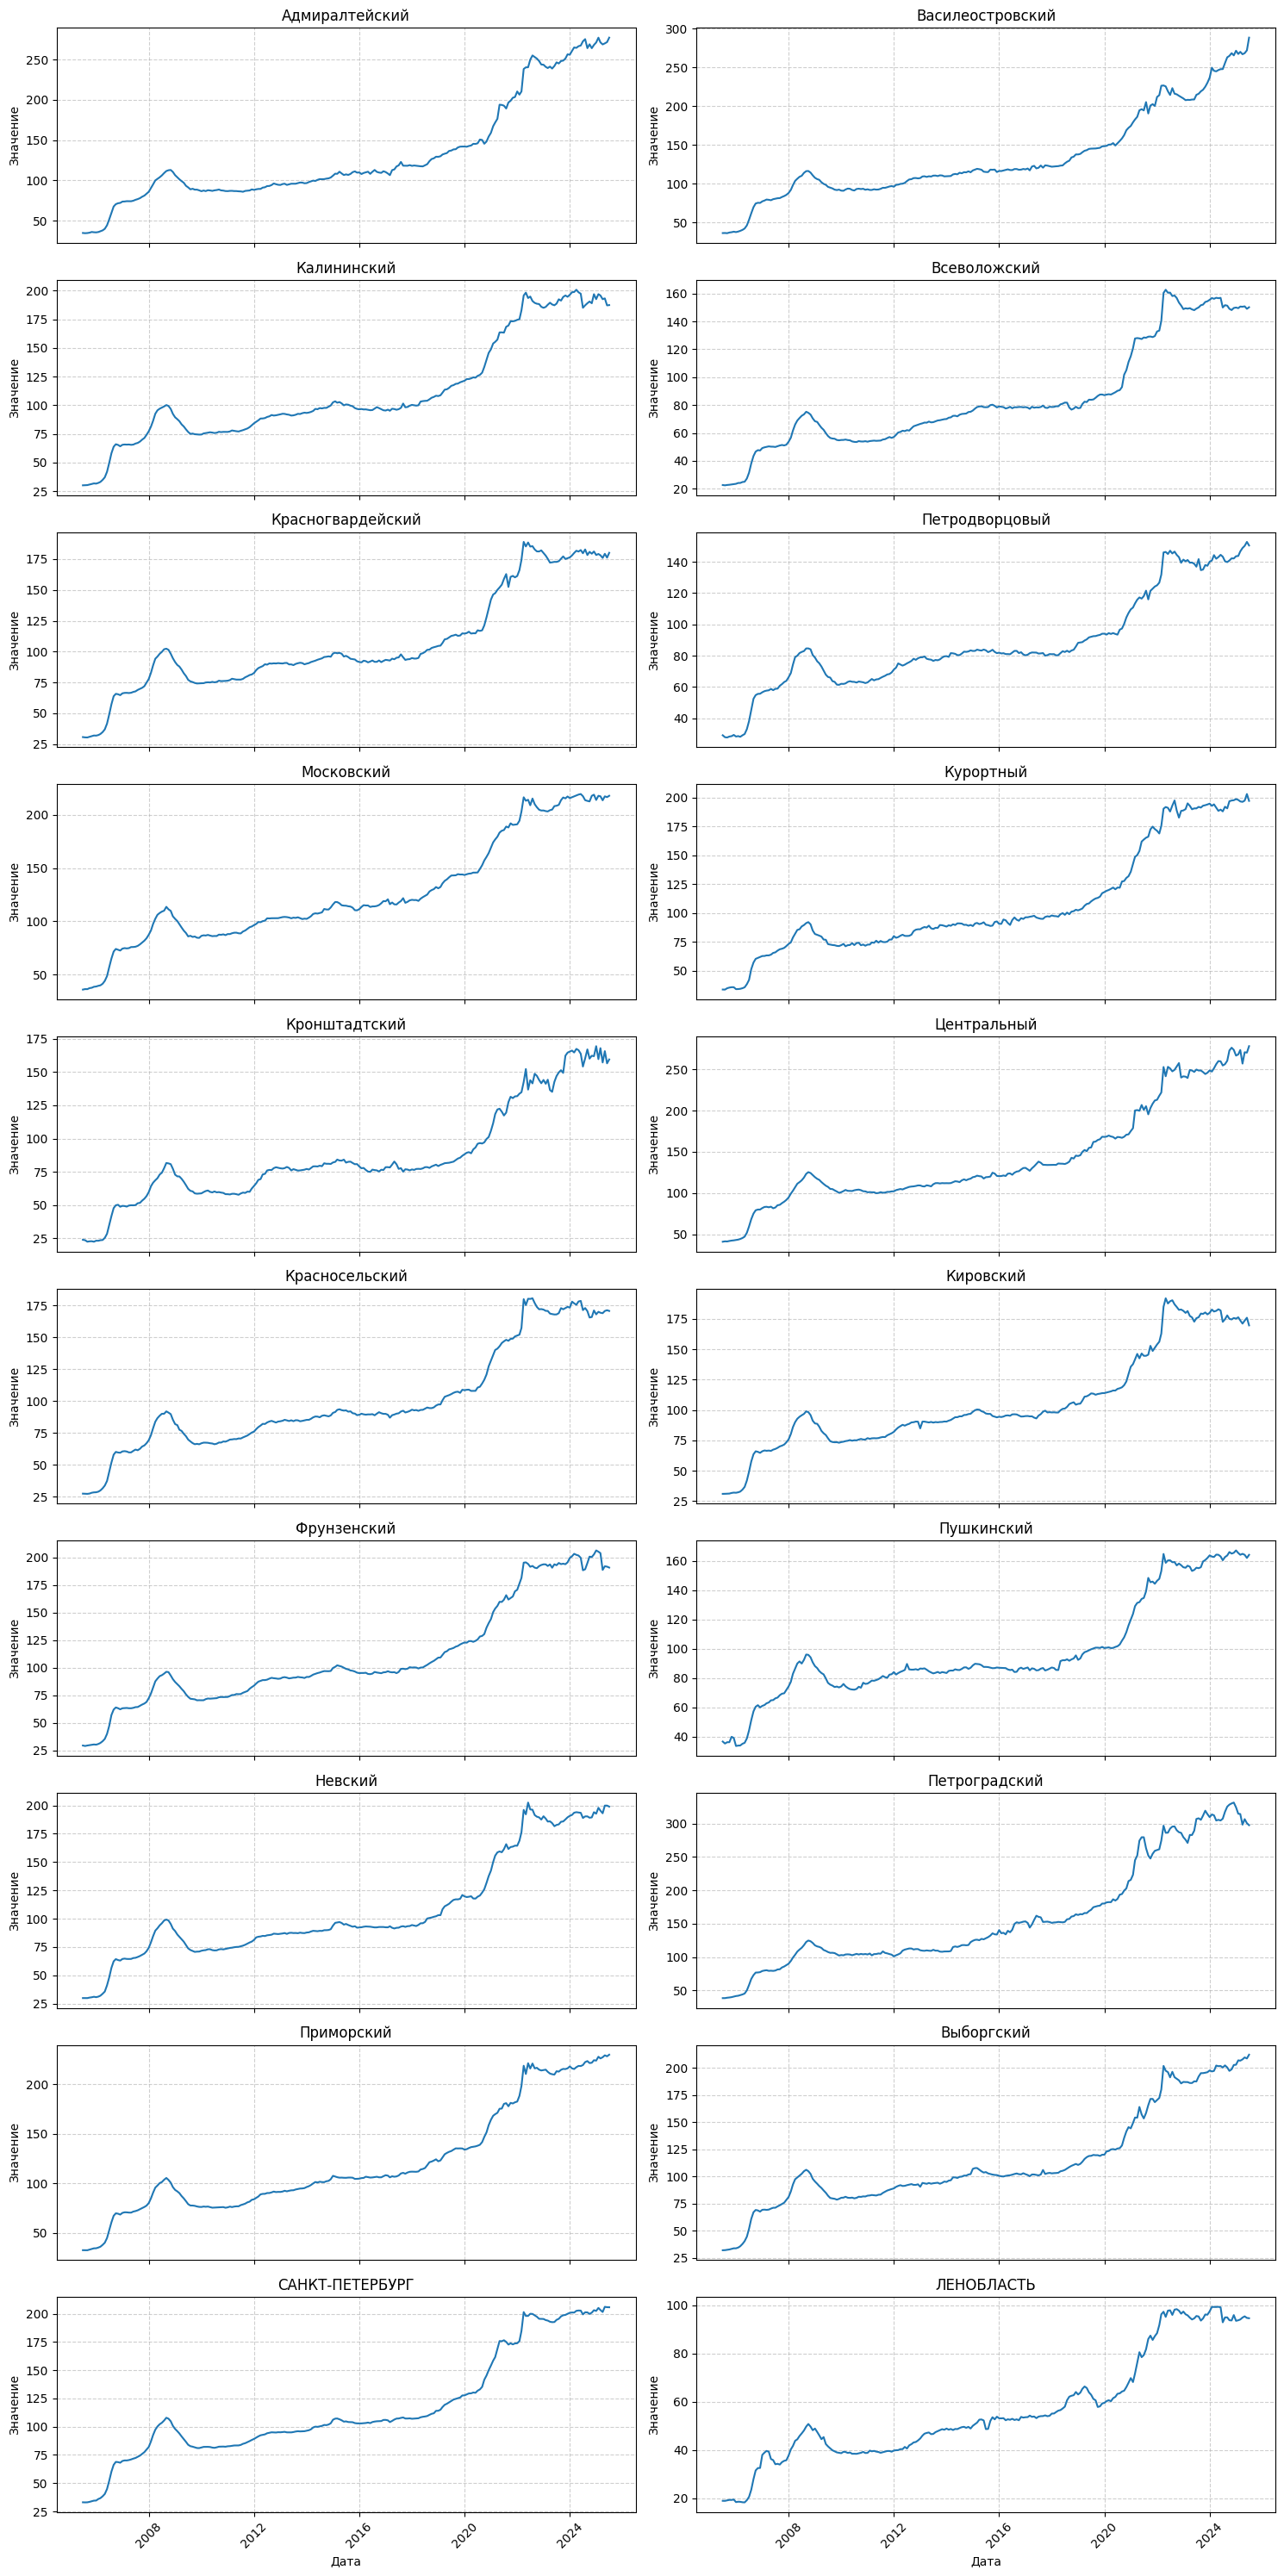

In [42]:


districts = [
    'o_Адмиралтейский',
    'o_Василеостровский', 
    'o_Калининский',
    'o_Всеволожский',
    'o_Красногвардейский',
    'o_Петродворцовый',
    'o_Московский',
    'o_Курортный',
    'o_Кронштадтский',
    'o_Центральный',
    'o_Красносельский',
    'o_Кировский',
    'o_Фрунзенский',
    'o_Пушкинский',
    'o_Невский',
    'o_Петроградский',
    'o_Приморский',
    'o_Выборгский',
    'o_CАНКТ-ПЕТЕРБУРГ',
    'o_ЛЕНОБЛАСТЬ'
]

n = len(districts)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows*3), sharex=True)
axes = axes.flatten()

for i, col in enumerate(districts):
    sns.lineplot(data=df, x='Дата', y=col, ax=axes[i], color='tab:blue')
    axes[i].set_title(col.replace('o_', ''))
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Значение')
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].tick_params(axis='x', rotation=45)

# Скрываем пустые оси
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Данные стали нагляднее. По результатам анализам видно, что все районы растут в цене по похожей схеме

## Заключение
1. Был проведён EDA над моим датасетом при помощи Jupyter Notebook.
2. Ноутбук был сохранён в `notebooks` под именем `EDA.ipynb`.
3. Были проведены оценки структуры, целостности и полноты данных, проанализированы полученные результаты.
4. Были построены графики для разных районов для наглядности представленных данных.